Project

Project:

Loading data

In [107]:
import numpy as np
from numpy.core.numeric import cross
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core.frame import DataFrame
from sklearn import tree
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

mat = pd.read_csv("Dataset/student-combined.csv", sep=';') # load dataset of the math classes 

mat.columns = ['school','sex','age','address','familySize','parentsStatus','motherEducation','fatherEducation',
        'motherJob','fatherJob','reason','guardian','commuteTime','studyTime','failures','schoolSupport',
        'familySupport','paidClasses','activities','nursery','desireHigherEdu','internet','romantic','familyQuality',
        'freeTime','goOutFriends','workdayAlc','weekendAlc','health','absences','1stPeriod','2ndPeriod','final']

for i in mat.columns:
    print(mat[i].value_counts())


GP    772
MS    272
Name: school, dtype: int64
F    591
M    453
Name: sex, dtype: int64
16    281
17    277
18    222
15    194
19     56
20      9
21      3
22      2
Name: age, dtype: int64
U    759
R    285
Name: address, dtype: int64
GT3    738
LE3    306
Name: familySize, dtype: int64
T    923
A    121
Name: parentsStatus, dtype: int64
4    306
2    289
3    238
1    202
0      9
Name: motherEducation, dtype: int64
2    324
1    256
3    231
4    224
0      9
Name: fatherEducation, dtype: int64
other       399
services    239
at_home     194
teacher     130
health       82
Name: motherJob, dtype: int64
other       584
services    292
teacher      65
at_home      62
health       41
Name: fatherJob, dtype: int64
course        430
home          258
reputation    248
other         108
Name: reason, dtype: int64
mother    728
father    243
other      73
Name: guardian, dtype: int64
1    623
2    320
3     77
4     24
Name: commuteTime, dtype: int64
2    503
1    317
3    162
4     62


Correlation:

In [108]:
mat.corr()['final'].sort_values()

failures          -0.383145
workdayAlc        -0.129642
age               -0.125282
weekendAlc        -0.115740
commuteTime       -0.102627
goOutFriends      -0.097877
health            -0.080079
freeTime          -0.064890
absences          -0.045671
familyQuality      0.054461
fatherEducation    0.159796
studyTime          0.161629
motherEducation    0.201472
1stPeriod          0.809142
2ndPeriod          0.910743
final              1.000000
Name: final, dtype: float64

Preparing data

In [109]:
mat['finalGrade'] = 'None'
mat.loc[(mat.final >= 13) & (mat.final <= 20), 'finalGrade'] = 1
mat.loc[(mat.final >= 0) & (mat.final <= 12), 'finalGrade'] = 0

X = mat.copy(deep=True) # copying mat without changing the original when X is changed

y = X['finalGrade'].ravel()
y = y.astype('int')

X['school'] = [0 if i == 'GP' else 1 for i in X['school']] # GP = 0, MS = 1
X['sex'] = [0 if i == 'M' else 1 for i in X['sex']] # M = 0, F = 1
X['address'] = [0 if i == 'U' else 1 for i in X['address']] # U = 0, R = 1
X['familySize'] = [0 if i == 'LE3' else 1 for i in X['familySize']] # LE3 = 0, GE3 = 1
X['parentsStatus'] = [0 if i == 'T' else 1 for i in X['parentsStatus']] # T = 0, A = 1
X['schoolSupport'] = [0 if i == 'no' else 1 for i in X['schoolSupport']] # no = 0, yes = 1
X['familySupport'] = [0 if i == 'no' else 1 for i in X['familySupport']] # no = 0, yes = 1
X['paidClasses'] = [0 if i == 'no' else 1 for i in X['paidClasses']] # no = 0, yes = 1
X['activities'] = [0 if i == 'no' else 1 for i in X['activities']] # no = 0, yes = 1
X['nursery'] = [0 if i == 'no' else 1 for i in X['nursery']] # no = 0, yes = 1
X['desireHigherEdu'] = [0 if i == 'no' else 1 for i in X['desireHigherEdu']] # no = 0, yes = 1
X['internet'] = [0 if i == 'no' else 1 for i in X['internet']] # no = 0, yes = 1
X['romantic'] = [0 if i == 'no' else 1 for i in X['romantic']] # no = 0, yes = 1

X = pd.get_dummies(X,columns=['motherJob','fatherJob','reason','guardian'])
X_proc = X.copy(deep=True)
X_proc.drop(['1stPeriod','2ndPeriod','final','finalGrade'], axis=1, inplace=True)
y_proc = np.asarray(y)
attribute_names = X_proc.columns
class_names = ['insufficient', 'sufficient']

X_proc = X_proc.values.tolist() # make X into a list(needed for creating a decision tree)
X_proc = np.asarray(X_proc)

Baseline:

In [111]:
sufficient = 0
insufficient = 0
for i in y:
    if i == 1: 
        sufficient += 1
    else:
         insufficient += 1

print(sufficient/insufficient)

0.6389324960753532


CrossValidation:

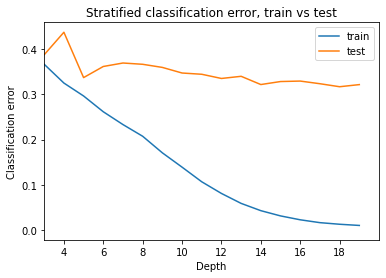

In [102]:
nr_of_splits = 40
max_depth = 20
train_error_list_stratified = np.zeros((nr_of_splits,max_depth))
test_error_list_stratified = np.zeros((nr_of_splits,max_depth))
for i, (train, test) in enumerate(StratifiedKFold(n_splits=nr_of_splits).split(X_proc,y_proc) ):
    X_train = X_proc[train]
    y_train = y_proc[train]
    X_test = X_proc[test]
    y_test = y_proc[test]
    for j in range (2,max_depth):
        train = []
        test = []
        dtc =  tree.DecisionTreeClassifier(max_depth = j)
        for k in range(10):
            dtc = dtc.fit(X_train, y_train)
            y_train_pred = dtc.predict(X_train)
            y_test_pred = dtc.predict(X_test)
            train_error = 1 - accuracy_score(y_train, y_train_pred)
            test_error = 1 - accuracy_score(y_test, y_test_pred)
            train.append(train_error)
            test.append(test_error)
        train_error_list_stratified[i, j] = np.average(train)
        test_error_list_stratified[i, j] = np.average(test_error) 

    
plt.title('Stratified classification error, train vs test')
plt.plot(train_error_list_stratified.mean(0), label = "train")
plt.plot(test_error_list_stratified.mean(0),label = "test")
plt.xticks(np.arange(0,max_depth,2))
plt.xlim([3,max_depth])
plt.ylabel('Classification error')
plt.xlabel('Depth')
plt.legend()
plt.show()

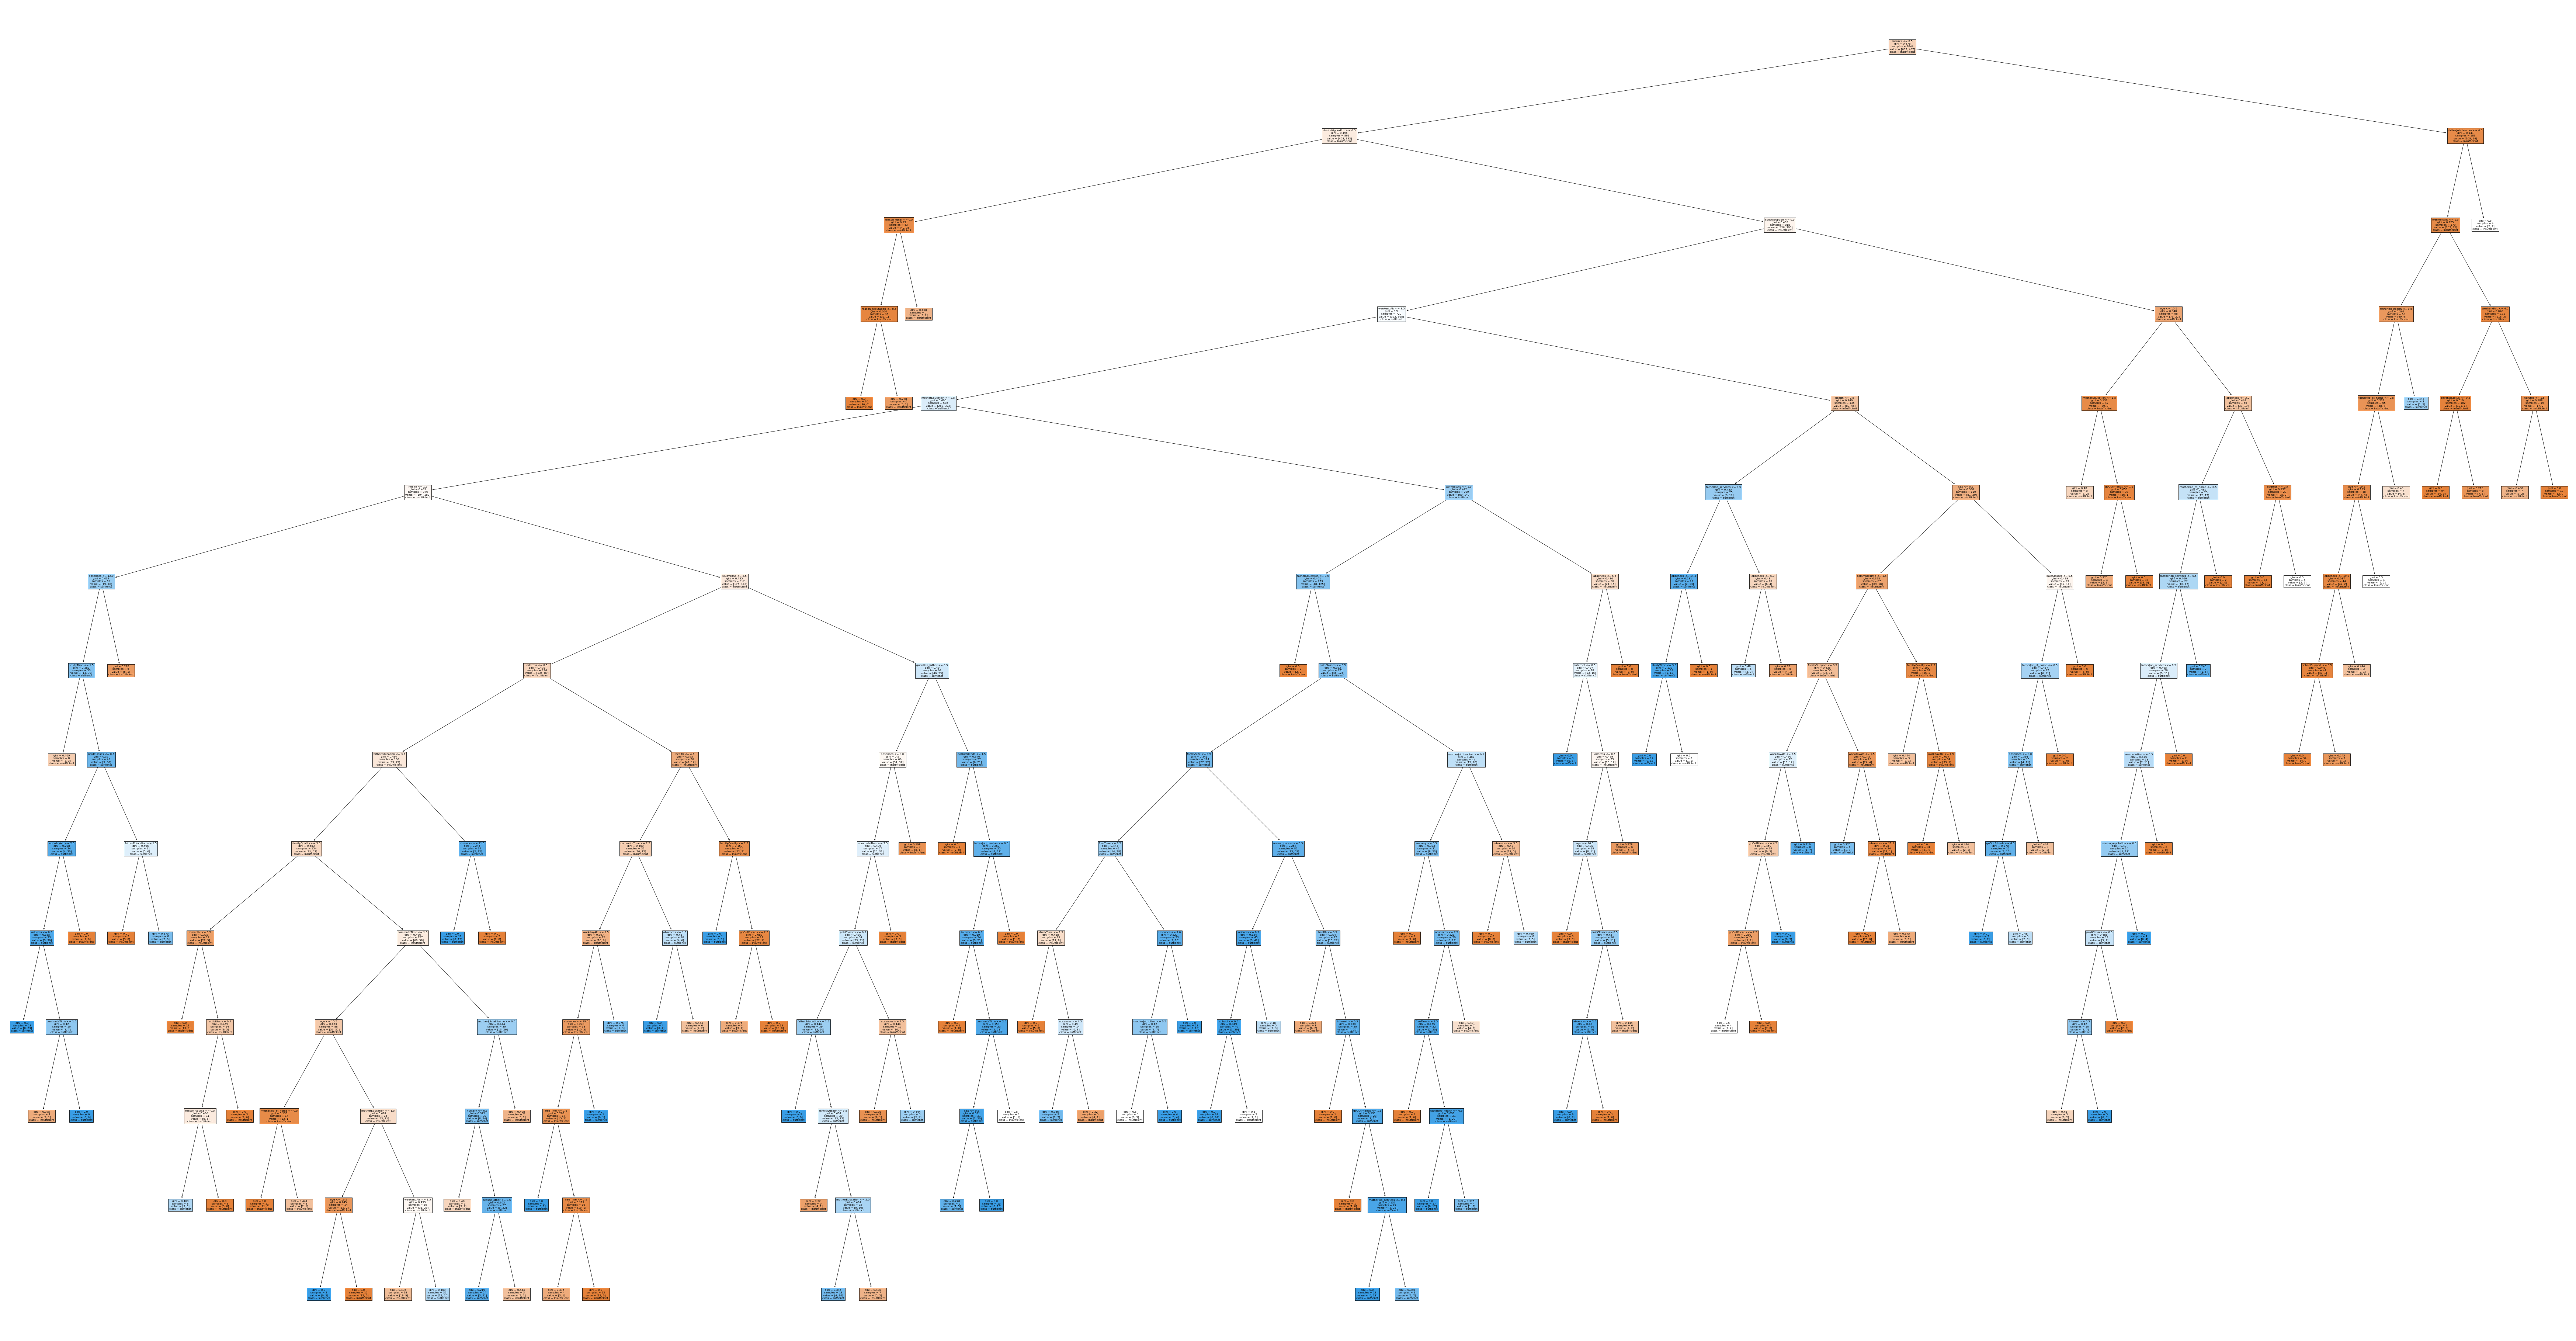

In [103]:
dtc = tree.DecisionTreeClassifier(max_depth=14, min_samples_split=10)
dtc = dtc.fit(X_proc, y_proc)
plt.figure(figsize=(150,80), dpi=60)

tree.plot_tree(dtc, feature_names = attribute_names, class_names = class_names, filled =True)
plt.savefig("decisiontreeNew.pdf")

Linear regression:

In [104]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X,y)
reg_score = reg.score(X,y)



Confussion Matrix

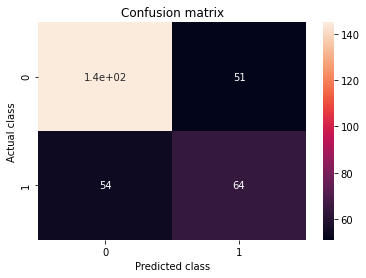

In [105]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, test_size=0.3, random_state=1234)
knClass = KNeighborsClassifier(n_neighbors= 5, metric='cosine').fit(X_train,y_train)
y_test_pred = knClass.predict(X_test)
cm = confusion_matrix(y_test,y_test_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)], columns = [i for i in np.unique(y)])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()

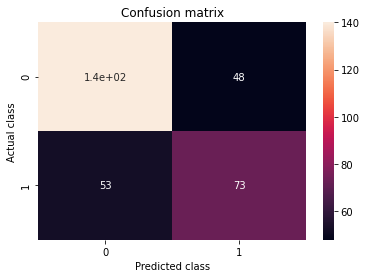

In [106]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
# for i in y:
#     print(i)
# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, test_size=0.3)
clf = GradientBoostingClassifier()

clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
cm = confusion_matrix(y_test,y_test_pred)
df_cm = pd.DataFrame(cm, index = [i for i in np.unique(y)], columns = [i for i in np.unique(y)])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual class')
plt.show()